# Swiftide evaluation with Ragas

This notebook demonstrates how to evaluate a Swiftide query pipeline with Ragas. The rust implementation is a bit contrived to make it more configurable. However, the main thing is running the query pipeline with an evaluator, and then exporting the result of that evaluator to a JSON file compatible with a HF dataset.

In the Rust code we use all features enabled as the base line, capturing the answers as the 'ground truth'.

**tl&dr; pretty charts at the bottom**

In [ ]:
# Run with all features and use the answers as the ground truths
!RUST_LOG=swiftide=info cargo run -- --language rust --path . --output base.json --record-ground-truth "How is swiftide used?" "How are arguments passed?" "How is Ragas used?"

In [ ]:
# Run with chunking enabled and QA metadata disabled
!RUST_LOG=swiftide=info cargo run --no-default-features --features=chunk -- --language rust --path . --output metadata.json --record-ground-truth --file base.json

In [ ]:
# Run with chunking disabled 
!RUST_LOG=swiftide=info cargo run --no-default-features --features=metadata -- --language rust --path . --output chunk.json --record-ground-truth --file base.json

In [ ]:
# Run with chunking and metadata disabled
!RUST_LOG=swiftide=info cargo run --no-default-features -- --language rust --path . --output nothing.json --record-ground-truth --file base.json

In [17]:
from datasets import load_dataset
files = { 
    "everything": "base.json",
    "metadata": "metadata.json",
    "chunk": "chunk.json",
    "nothing": "nothing.json"
}
dataset = load_dataset("json", data_files=files)

dataset

Generating everything split: 0 examples [00:00, ? examples/s]

Generating metadata split: 0 examples [00:00, ? examples/s]

Generating chunk split: 0 examples [00:00, ? examples/s]

Generating nothing split: 0 examples [00:00, ? examples/s]

DatasetDict({
    everything: Dataset({
        features: ['answer', 'contexts', 'ground_truth', 'question'],
        num_rows: 3
    })
    metadata: Dataset({
        features: ['answer', 'contexts', 'ground_truth', 'question'],
        num_rows: 3
    })
    chunk: Dataset({
        features: ['answer', 'contexts', 'ground_truth', 'question'],
        num_rows: 3
    })
    nothing: Dataset({
        features: ['answer', 'contexts', 'ground_truth', 'question'],
        num_rows: 3
    })
})

In [20]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

import pandas as pd

from ragas import evaluate

# Run evaluate on each dataset, add a column with the dataset name, then concat into single dataframe
all_results = []
for key in files:
    result = evaluate(dataset[key], metrics=[answer_relevancy,faithfulness,context_recall,context_precision]).to_pandas()
    result['dataset'] = key
    all_results.append(result)
    
df = pd.concat(all_results)
df



Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

,answer,contexts,ground_truth,question,answer_relevancy,faithfulness,context_recall,context_precision,dataset
0,```markdown\nSwiftide is used for indexing cod...,"[""use swiftide::{\n indexing::{\n lo...",```markdown\nSwiftide is used for indexing cod...,How is swiftide used?,0.900142,1.000000,1.00,1.0,everything
1,```markdown\nArguments are passed in the conte...,"[""\nstruct Args {\n #[arg(short, long)]\n ...",```markdown\nArguments are passed in the conte...,How are arguments passed?,0.914773,1.000000,1.00,1.0,everything
2,```markdown\nRagas is used in the context of t...,"[""\n\nasync fn query(\n questions: Evaluati...",```markdown\nRagas is used in the context of t...,How is Ragas used?,0.894912,1.000000,0.75,1.0,everything
0,```markdown\nArguments are passed using a stru...,"[""\nstruct Args {\n #[arg(short, long)]\n ...",```markdown\nArguments are passed using a stru...,How are arguments passed?,0.941746,1.000000,1.00,1.0,metadata
1,```markdown\nRagas is used in the context of e...,"[""\n\nasync fn query(\n questions: Evaluati...",```markdown\nRagas is used in the context of e...,How is Ragas used?,0.922148,1.000000,1.00,1.0,metadata
2,```markdown\nSwiftide is used to index code an...,"[""use swiftide::{\n indexing::{\n lo...",```markdown\nSwiftide is used to index code an...,How is swiftide used?,0.860102,1.000000,1.00,1.0,metadata
0,```markdown\nRagas is used in the context of e...,"[""use swiftide::{\n indexing::{\n lo...",```markdown\nRagas is used in the context of e...,How is Ragas used?,0.930633,0.928571,1.00,1.0,chunk
1,```markdown\nSwiftide is used in the context o...,"[""use swiftide::{\n indexing::{\n lo...",```markdown\nSwiftide is used in the context o...,How is swiftide used?,0.927046,1.000000,1.00,1.0,chunk
2,```markdown\nArguments are passed in the conte...,"[""use swiftide::{\n indexing::{\n lo...",```markdown\nArguments are passed in the conte...,How are arguments passed?,0.791580,1.000000,1.00,1.0,chunk
0,## How is Ragas used?\n\nRagas is used in the ...,"[""use swiftide::{\n indexing::{\n lo...",## How is Ragas used?\n\nRagas is used in the ...,How is Ragas used?,0.913439,1.000000,1.00,1.0,nothing


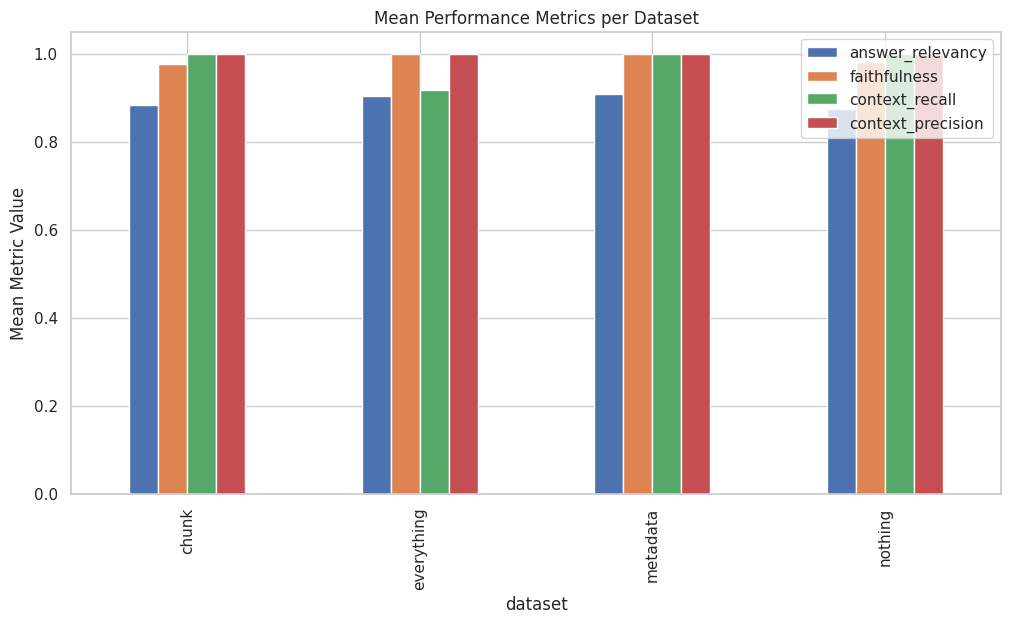

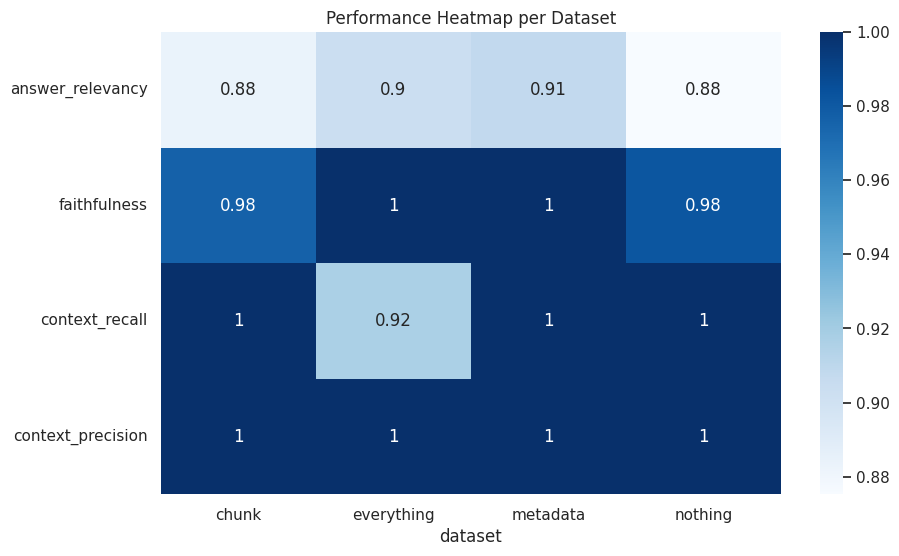

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping by dataset and calculating the mean
df_grouped = df.groupby('dataset').mean(True).reset_index()

# 1. Bar Chart
df_grouped.plot(x='dataset', kind='bar', figsize=(12, 6), title='Mean Performance Metrics per Dataset')
plt.ylabel('Mean Metric Value')
plt.show()

# 2. Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_grouped.set_index('dataset').T, annot=True, cmap='Blues')
plt.title('Performance Heatmap per Dataset')
plt.show()
